# Census Income Project
### Problem Statement:


This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The prediction task is to determine whether a person makes over $50K a year.
Description of fnlwgt (final weight)

The weights on the Current Population Survey (CPS) files are controlled to independent estimates of the civilian non-institutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are:

    A single cell estimate of the population 16+ for each state.

    Controls for Hispanic Origin by age and sex.

    Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.

In [5]:
# 1. Import the libraries
# basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# statistical libraries
import phik
from scipy.stats import pearsonr
from scipy.stats import zscore

# feature engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# metrics 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, classification_report

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/dsrscientist/dataset1/master/census_income.csv')

In [7]:
# Checking the dataset
df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [8]:
# check for the data statistics and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       32560 non-null  object
 2   Fnlwgt          32560 non-null  int64 
 3   Education       32560 non-null  object
 4   Education_num   32560 non-null  int64 
 5   Marital_status  32560 non-null  object
 6   Occupation      32560 non-null  object
 7   Relationship    32560 non-null  object
 8   Race            32560 non-null  object
 9   Sex             32560 non-null  object
 10  Capital_gain    32560 non-null  int64 
 11  Capital_loss    32560 non-null  int64 
 12  Hours_per_week  32560 non-null  int64 
 13  Native_country  32560 non-null  object
 14  Income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [9]:
# Checking for null values 
df.isnull().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

there aren't any null values

In [10]:
# checking for the data statistics
df.describe().round()

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week
count,32560.0,32560.0,32560.0,32560.0,32560.0,32560.0
mean,39.0,189782.0,10.0,1078.0,87.0,40.0
std,14.0,105550.0,3.0,7385.0,403.0,12.0
min,17.0,12285.0,1.0,0.0,0.0,1.0
25%,28.0,117832.0,9.0,0.0,0.0,40.0
50%,37.0,178363.0,10.0,0.0,0.0,40.0
75%,48.0,237054.0,12.0,0.0,0.0,45.0
max,90.0,1484705.0,16.0,99999.0,4356.0,99.0


In [51]:
# looking for zero values since, Capital_gain and Capital_loss have huge standard deviations
from pandas.api.types import is_numeric_dtype
for col in df.columns:
    if is_numeric_dtype(df[col]):
        print(f"%age zeros in {col:20s} : {np.where(df[col] == 0)[0].shape[0]/len(df)}")

%age zeros in Age                  : 0.0
%age zeros in Fnlwgt               : 0.0
%age zeros in Education_num        : 0.0
%age zeros in Hours_per_week       : 0.0


Apparently Capital_gain and Capital_loss have a very large number of zeros and hence we discard the two

In [21]:
df.drop(columns = ['Capital_gain', 'Capital_loss'], inplace = True)

In [23]:
# Next we check for the distribution of the numeric columns
numeric_col = []
for col in df.columns:
    if is_numeric_dtype(df[col]):
        numeric_col.append(col)

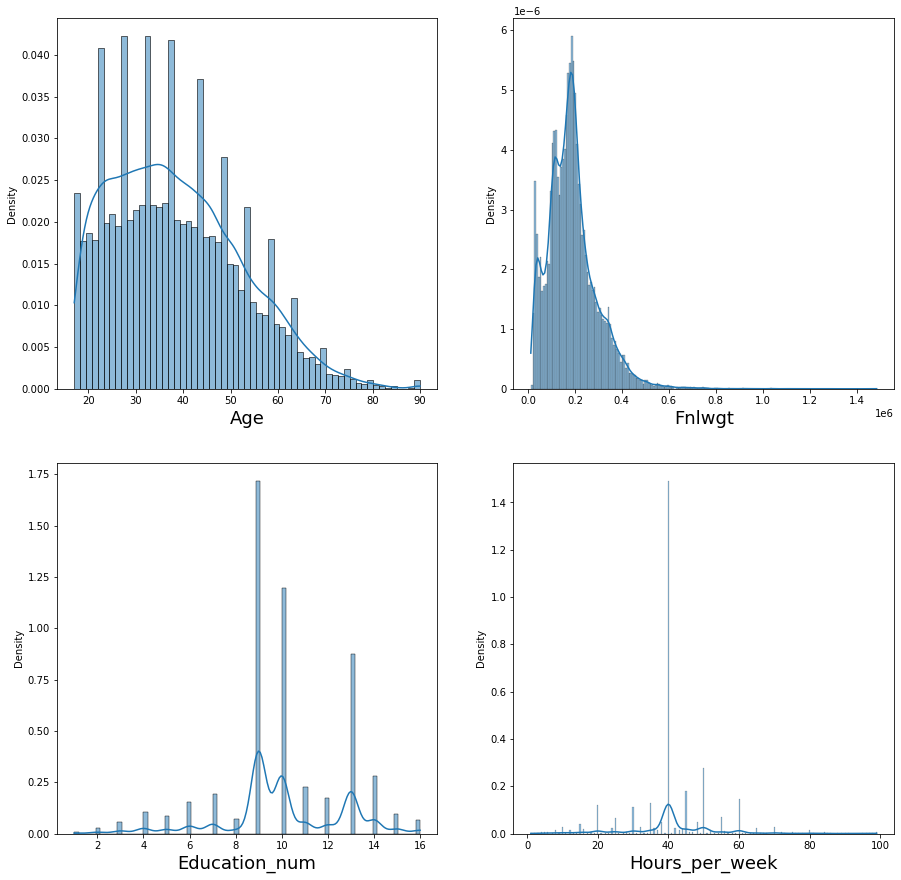

In [24]:
plt.figure(figsize = (15, 15))
plotnumber = 1
for col in numeric_col:
    plt.subplot(2,2, plotnumber)
    sns.histplot(df[col], kde = True, stat = 'density')
    plt.xlabel(col, fontsize = 18)
    plotnumber += 1
plt.show()

Education number apparently is a categorical encoded dataset and hence we remove it from our lists of numeric columns.For the remaining three we check the box plot for outliers

In [25]:
numeric_col.remove('Education_num')

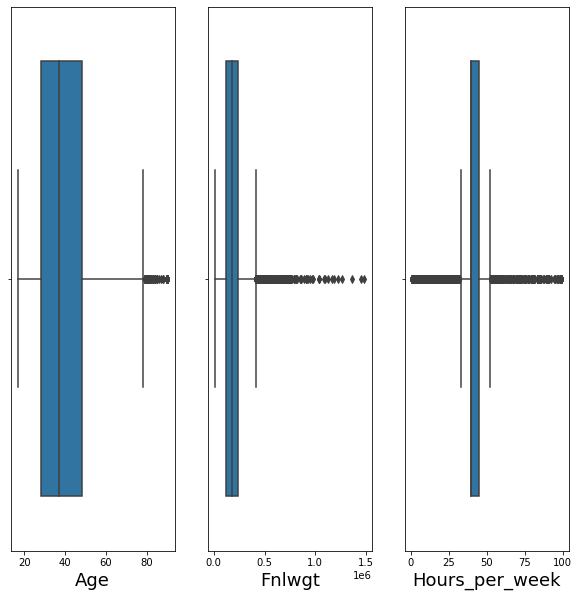

In [27]:
plt.figure(figsize = (10, 10))
plotnumber = 1
for col in numeric_col:
    plt.subplot(1,3, plotnumber)
    sns.boxplot(df[col], orient = 'h')
    plt.xlabel(col, fontsize = 18)
    plotnumber += 1

In [29]:
# first we estimate the number of outliers in each feature before we attempt to remove them
from scipy.stats import zscore

In [46]:
sum = 0
for col in numeric_col:
    sum += len(df[(np.abs(zscore(df[[col]]))>3.).all(axis = 1)])

In [52]:
# %age of data that would be lost is we remove the outliers
print(f"%age of data lost : {sum/len(df)*100:0.2f}%")

%age of data lost : 2.79%


In [54]:
# Hence we got about removing the outliers from the dataset
for col in numeric_col:
    df = df[(np.abs(zscore(df[[col]]))<3.).all(axis = 1)]


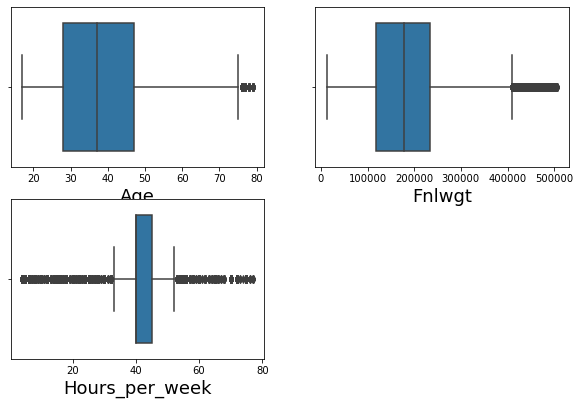

In [60]:
# plotting the values again to check if the if the outliers have be removed
plt.figure(figsize = (10, 10))
plotnumber = 1
for col in numeric_col:
    plt.subplot(3,2,plotnumber)
    sns.boxplot(df[col], orient = 'h')
    plt.xlabel(col, fontsize = 18)
    plotnumber += 1
plt.show()

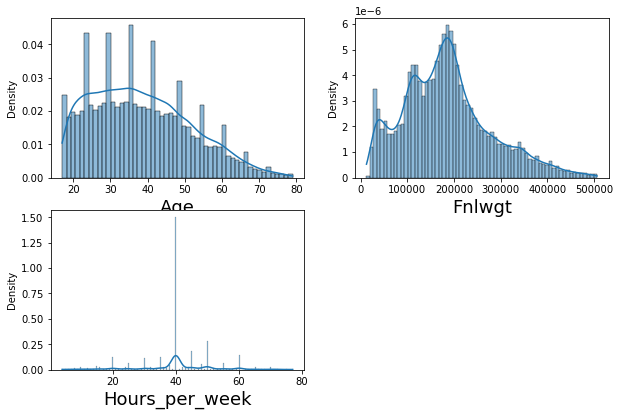

In [61]:
plt.figure(figsize = (10, 10))
plotnumber = 1
for col in numeric_col:
    plt.subplot(3,2,plotnumber)
    sns.histplot(df[col], kde = True, stat = 'density')
    plt.xlabel(col, fontsize = 18)
    plotnumber += 1
plt.show()

The hours per week still have some outliers which we will try and remove using the quantile range

In [64]:
q1 = df['Hours_per_week'].quantile(0.25)
q3 = df['Hours_per_week'].quantile(0.75)

In [65]:
iqr = q3 - q1
lo  = q1 - 1.5 * iqr
hi  = q3 + 1.5 * iqr

low_indices = np.where(df['Hours_per_week'] > hi)
high_indices= np.where(df['Hours_per_week'] < lo)

In [70]:
low_indices[0].shape[0]/len(df)*100

9.829802014588399

In [72]:
high_indices[0].shape[0]/len(df)*100

16.754554927531657

In [73]:
# we lose 25% of our data, which is quite high and hence we drop the feature all together

In [74]:
df.drop('Hours_per_week', axis = 1, inplace =True)

In [80]:
# The Education columns and the education num both are the same column, the latter being encoded and hence we must drop it
df.drop('Education', axis = 1, inplace = True)

In [84]:
# The final weight is the target variable
y = df['Fnlwgt']
x = df.drop('Fnlwgt', axis = 1)
import phik

In [87]:
temp = pd.DataFrame()
pvalue = []
score  = []
feature= []
for col in x.columns:
    if(is_numeric_dtype(x[col])):
        score.append(phik.phik_from_array(x[col], y, [col]))
        pvalue.append(phik.significance.significance_from_array(x[col], y, [col])[0])
        feature.append(col)
    else:
        score.append(phik.phik_from_array(x[col], y))
        pvalue.append(phik.significance.significance_from_array(x[col], y)[0])
        feature.append(col)

In [88]:
temp['Features'] = feature
temp['Score'] = score
temp['pvalue']= pvalue

In [97]:
temp.set_index('Features', inplace = True)

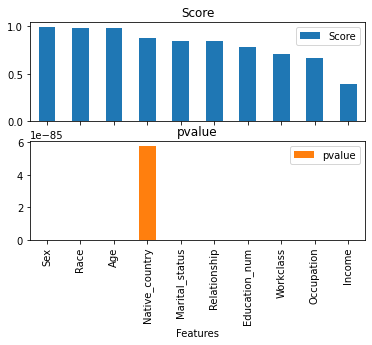

In [100]:
temp.sort_values('Score', ascending  = False).plot.bar(subplots = True)
plt.show()

In [102]:
# All the features share a high score with the target values, especially the Sex, Race and Age

In [105]:
# We encode the data next 
categorical_col = [col for col in x.columns if not (is_numeric_dtype(df[col]))]

In [106]:
categorical_col

['Workclass',
 'Marital_status',
 'Occupation',
 'Relationship',
 'Race',
 'Sex',
 'Native_country',
 'Income']

In [113]:
# Checking for the variance in each of the features
for col in categorical_col:
    print(f"{col:20s} : {df[col].unique().shape[0]/len(df)*100:2f}%")

Workclass            : 0.028419%
Marital_status       : 0.022104%
Occupation           : 0.047365%
Relationship         : 0.018946%
Race                 : 0.015788%
Sex                  : 0.006315%
Native_country       : 0.132622%
Income               : 0.006315%


In [119]:
for col in categorical_col:
    if df[col].unique().shape[0] == 1:
        print(f"{col:20s}")

There isn't a wide variance within the dataset and there is also no features with one unique value 

In [122]:
# Next we encode the values 
df['Workclass'].unique()

array([' Self-emp-not-inc', ' Private', ' State-gov', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay',
       ' Never-worked'], dtype=object)

In [127]:
# Since the WorkClass feature has some missing values
print(f"{np.where(df['Workclass'] == ' ?')[0].shape[0]/len(df) * 100:0.2f}%")

5.47%


In [162]:
df.reset_index(inplace = True)

In [163]:
# We decide to drop the missing values from the dataset
indices = np.where(df['Workclass'] == ' ?')[0]

In [165]:
df.drop(index = indices, inplace = True)

In [167]:
df.drop('index', inplace = True, axis = 1)

In [168]:
df

,Age,Workclass,Fnlwgt,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Native_country,Income
0,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
1,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
2,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
3,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K
4,37,Private,284582,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...
31664,27,Private,257302,12,Married-civ-spouse,Tech-support,Wife,White,Female,United-States,<=50K
31665,40,Private,154374,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States,>50K
31666,58,Private,151910,9,Widowed,Adm-clerical,Unmarried,White,Female,United-States,<=50K
31667,22,Private,201490,9,Never-married,Adm-clerical,Own-child,White,Male,United-States,<=50K


In [170]:
# Label Encoding the WorkClass feature
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [172]:
df['Workclass'] = le.fit_transform(df['Workclass'])

In [174]:
# Encoding the Marital Status
df['Marital_status'] = le.fit_transform(df['Marital_status'])

In [176]:
# Encoding the Occupation 
df['Occupation'].unique()

array([' Exec-managerial', ' Handlers-cleaners', ' Prof-specialty',
       ' Other-service', ' Adm-clerical', ' Sales', ' Craft-repair',
       ' Transport-moving', ' Farming-fishing', ' Machine-op-inspct',
       ' Tech-support', ' Protective-serv', ' Armed-Forces',
       ' Priv-house-serv', ' ?'], dtype=object)

In [182]:
# There are missing values
indices = np.where(df == ' ?')[0]

In [196]:
# dropping all the missing values
df = df.reset_index().drop(index = indices)

In [197]:
df.drop('index', axis = 1, inplace = True)

In [199]:
# Encoding ghe Occupation feature
df['Occupation'] = le.fit_transform(df['Occupation'])

In [203]:
df['Relationship'] = le.fit_transform(df['Relationship'])

In [206]:
df['Race'] = le.fit_transform(df['Race'])

In [210]:
df['Sex'] = pd.get_dummies(df['Sex'], drop_first = True)

In [214]:
df['Native_country'] = le.fit_transform(df['Native_country'])

In [219]:
df['Income'] = pd.get_dummies(df['Income'], drop_first = True)

In [220]:
df

,Age,Workclass,Fnlwgt,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Native_country,Income
0,50,5,83311,13,2,3,0,4,1,38,0
1,38,3,215646,9,0,5,1,4,1,38,0
2,53,3,234721,7,2,5,0,2,1,38,0
3,28,3,338409,13,2,9,5,2,0,4,0
4,37,3,284582,14,2,3,5,4,0,38,0
...,...,...,...,...,...,...,...,...,...,...,...
29932,27,3,257302,12,2,12,5,4,0,38,0
29933,40,3,154374,9,2,6,0,4,1,38,1
29934,58,3,151910,9,6,0,4,4,0,38,0
29935,22,3,201490,9,4,0,3,4,1,38,0


In [221]:
# split the dataset in the training variables and target variable
x = df.drop('Fnlwgt', axis = 1)
y = df['Fnlwgt']

In [ ]:
# Standardize the data
x_standardized = StandardScaler().fit_transform(x)

In [223]:
# split the dataset into a training and testing set
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size = 0.25, random_state = 42)

In [224]:
estimators = []

lr = LinearRegression()
estimators.append(('Linear Regressor',lr))
dt = DecisionTreeRegressor()
estimators.append(('Decision Tree Regressor',dt))
kn = KNeighborsRegressor()
estimators.append(('K-Neighbors Regressor',kn))

In [225]:
# fit the estimators 
for estimator in estimators:
    estimator[1].fit(xtrain, ytrain)
    ypred = estimator[1].predict(xtest)
    print(estimator[0])
    print(f'{mean_squared_error(ypred, ytest,squared = False):0.3f}')
    print(f'{r2_score(ypred, ytest):0.3f}')

Linear Regressor
94084.528
-67.349
Decision Tree Regressor
125765.524
-0.964
K-Neighbors Regressor
101008.523
-3.928


The linear regression model is found to have smallest mean squared error and also high r2 coeffcient. We can attempt to fine tune the linear regression model in order to find a better estimate

In [226]:
# using LassoCV to find better parameters for the Linear Regression
from sklearn.linear_model import LassoCV
lcv = LassoCV()
lcv.fit(xtrain, ytrain)
ypred2 = lcv.predict(xtest)
print(f'{mean_squared_error(ypred2, ytest, squared = False):0.3f}')
print(f'{r2_score(ytest, ypred2):0.3f}')

94083.879
0.011


In [227]:
# Using Elastic Net regularization
from sklearn.linear_model import ElasticNetCV
ecv = ElasticNetCV()
ecv.fit(xtrain, ytrain)
ypred3 = ecv.predict(xtest)
print(f'{mean_squared_error(ytest, ypred3, squared = False):0.3f}')
print(f'{r2_score(ytest, ypred3):0.3f}')

94278.494
0.007


In [228]:
# Using L2 regularization
from sklearn.linear_model import RidgeCV
rcv = RidgeCV()
rcv.fit(xtrain, ytrain)
ypred4 = rcv.predict(xtest)
print(f'{mean_squared_error(ytest, ypred4, squared = False):0.3f}')
print(f'{r2_score(ytest, ypred4):0.3f}')

94084.524
0.011


<font color = green>
The linear regression regularized using the RidgeCV gives the lowest error and highest R2 score even compared to other Regression models. Hence it will be selected
</font>

In [229]:
# saving the model
import joblib
joblib.dump(rcv, 'L2_regularized_linear_model.pkl')

['L2_regularized_linear_model.pkl']